In [55]:
import os
import sys

sys.path.append('../')

import h5py
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numba
import numpy as np
import torch
from numpy.fft import fft, fft2, fftshift, ifft, ifft2, ifftshift
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

from kwave.ktransducer import *
from kwave.utils import *
from models.ADMM import ADMM_Batched
from models.FISTA import FISTA_Batched
from models.HQS import HQS_Batched
from models.WienerNet import Wiener_Batched, WienerNet
from utils.simulations import PSF, center, wavefront_real
from utils.utils_torch import get_fourier_coord

os.environ["CUDA_VISIBLE_DEVICES"] = '2'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Load in Brain Data

(512, 2000)


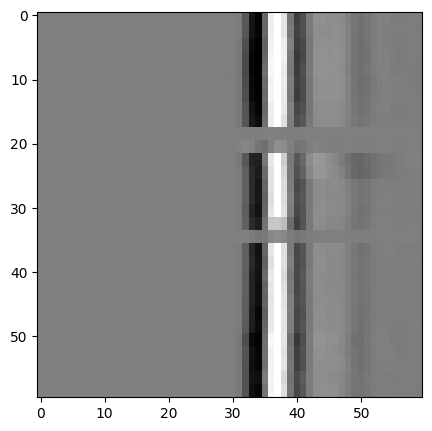

In [56]:
data = h5py.File('data/MATLAB_DATA_2_superbliver/layer1.mat')
sinogram = np.array(data['Sinogram'])
print(sinogram.shape)
plt.subplots(figsize=(16,5))
plt.imshow(sinogram[40:100,40:100], cmap='gray')
plt.show()

### Load and Deconvolve EIR

(1, 2000)


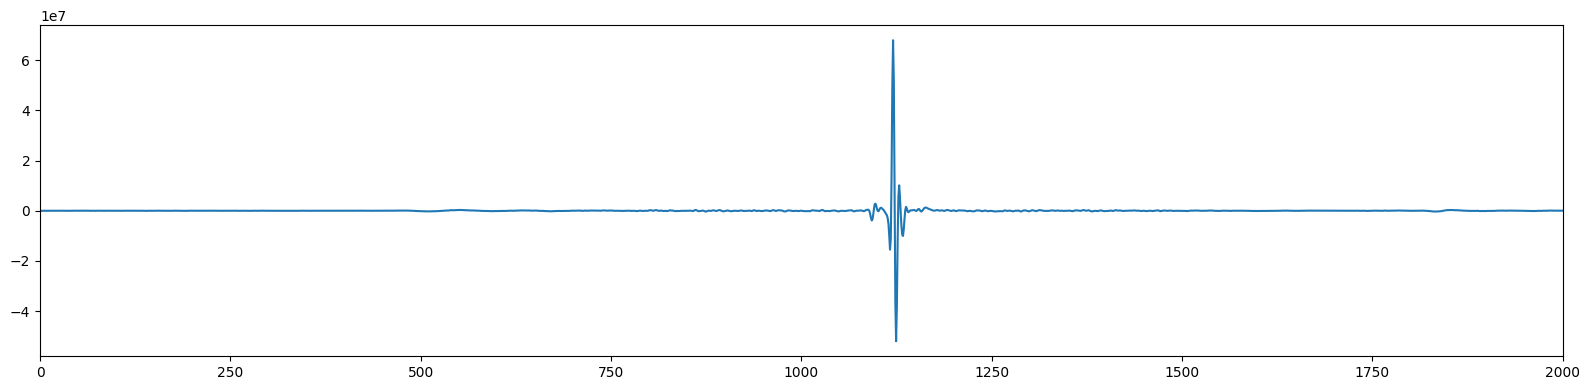

In [57]:
EIR_data = h5py.File('data/EIR_TUNGSTEN.mat')
EIR = np.array(EIR_data['EIR_AVE_20180516_LEFT'])
print(EIR.shape)

time = np.linspace(0, 2000, 2000)
plt.figure(figsize=(16,4))
plt.plot(time, np.squeeze(EIR[:2000]))
plt.xlim(0, 2000)
plt.tight_layout()

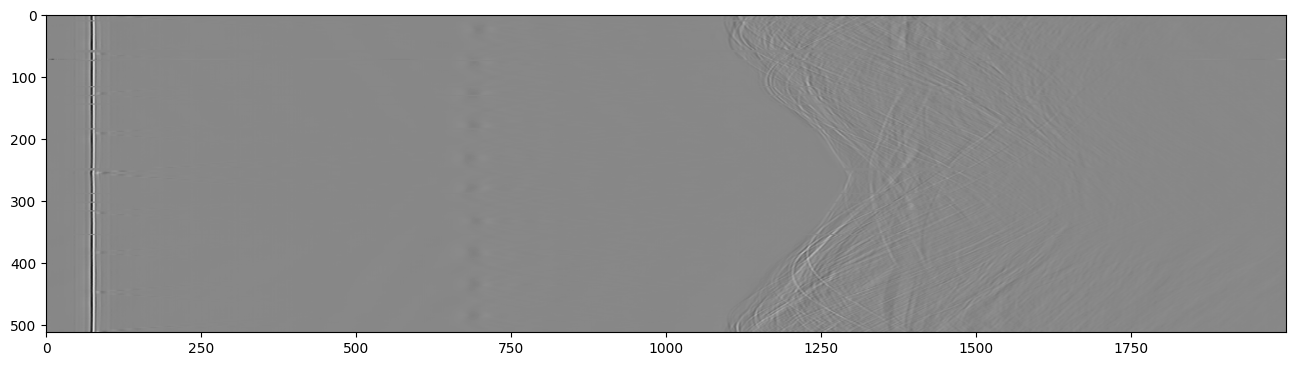

In [58]:
def deconvolve_sinogram(sinogram, EIR, t0):
    """Correct EIR phase of the sinogram.

    Args:
        sinogram (`numpy.array`): _description_
        EIR (`numpy.array`): EIR of the transducer.
        t0 (`int`): Time index of the EIR peak.

    Returns:
        `numpy.array`: The corrected sinogrm.
    """
    delta = np.zeros_like(EIR)
    delta[0, t0] = 1
    delta_ft = fft(delta, axis=1)
    EIR_ft = fft(EIR, axis=1)
    Sinogram_ft = fft(sinogram, axis=1)
    Sinogram_ft *= np.exp(1j * (np.angle(delta_ft) - np.angle(EIR_ft)))
    
    return np.real((ifft(Sinogram_ft, axis=1)))

t0 = np.argmax(EIR)    
sinogram_deconv = deconvolve_sinogram(sinogram, EIR, t0)
plt.subplots(figsize=(16,5))
plt.imshow(sinogram_deconv, cmap='gray')
plt.show()

In [59]:
Nx, Ny = 750, 750
R_ring = 0.05   # Radius of the ring array [m].
dx, dy = 4e-5, 4e-5
kgrid = kWaveGrid([Nx, Ny], [dx, dy])

In [60]:
def get_water_SoS(t):
    """Calculate the speed of sound of water at temperature `t` in Celsius."""
    a = [1.402385e3, 5.038813, -5.799136e-2, 3.287156e-4, -1.398845e-6, 2.787860e-9]
    SoS = 0
    for i in range(len(a)):
        SoS += a[i] * t**i
    return SoS

R = 6.9e-3 # Radius to center [m].
l = 3.2e-3 # Patch size [m].
T = 31.6 # Temperature of water [C].
v0 = get_water_SoS(T) # SoS in water [m/s].
v1 = 1525. # Average SoS in tissue [m/s].
print(v0, v1)

1512.7691170578064 1525.0


Load ring error.

(256,) (256,)


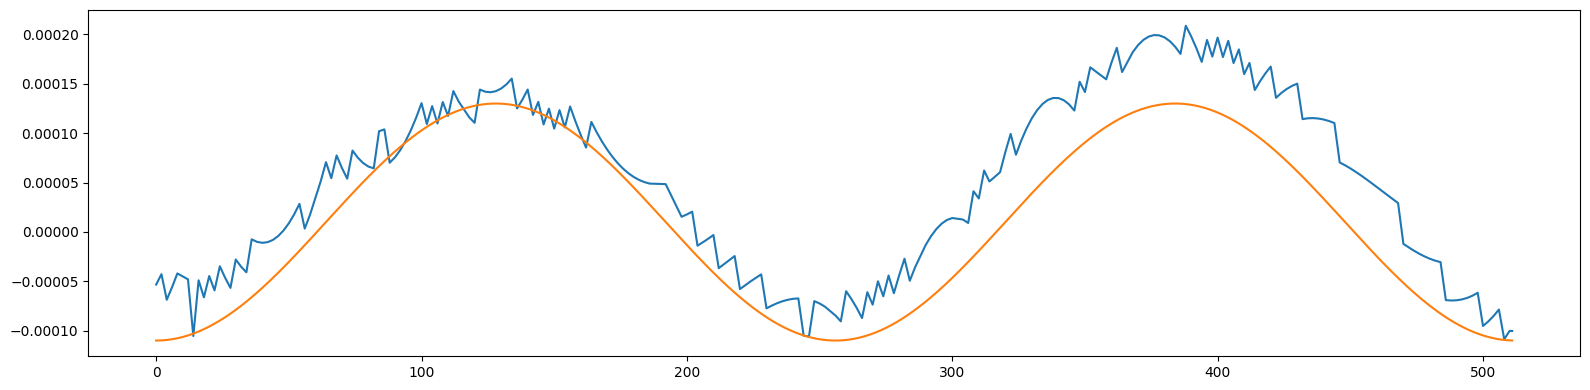

In [61]:
data = h5py.File('data/RING_ERROR_NEW.mat')
ring_error, transducer_theta = np.array(data['e'])[:,0], np.array(data['transducer_theta'])[:,0]
print(ring_error.shape, transducer_theta.shape)

idx = np.arange(0, 512, 1)
ring_error = np.interp(idx, np.arange(0, 512, 2), ring_error) # Upsample ring error.
ring_error_1 = -40e-6 - 120e-6 * np.cos(2 * idx * 2 * np.pi/512) + 5e-5
plt.figure(figsize=(16,4))
plt.plot(idx, ring_error)
plt.plot(idx, ring_error_1)
plt.tight_layout()

In [62]:
@numba.jit(nopython=True) 
def delay_and_sum(R_ring, T_sample, V_sound, Sinogram, ImageX, ImageY, d_delay=0, ring_error=0):
    """Generate a 2D Delay And Sum recontructed PACT image of ring transducer array. This function is accelerated by `numba.jit` on a GPU.

    Args:
        R_ring (`float`): The R_ring [m] of the ring transducer array.
        T_sample (`float`): Sample time interval [s] of the signals.
        V_sound (`float`): The sound speed [m/s] used for Delay And Sum recontruction.
        Sinogram (`numpy.ndarray`): A 2D array and each column of it is the signal recievde by one transducer. The nummber of transducers should be the number of columns. The transducers should be evenly distributed on a circle in counterclockwise arrangement and the first column correspond to the transducer in the dirrection `2pi/N` in the first quartile. The first sample should be at time 0 when the photoacoustic effect happens.
        ImageX (`numpy.ndarray`): The vector [m] defining the x coordinates of the grid points on which the recontruction is done. The values in the vector should be unifromly-spaced in ascending order. The origin of the cartesian coordinate system is the center of the ring array.
        ImageY (`numpy.ndarray`): The vector [m] defining the y coordinates of the grid points on which the recontruction is done. The values in the vector should be unifromly-spaced in ascending order. The origin of the cartesian coordinate system is the center of the ring array.
        d_delay (`float`): The delay distance [m] of the signals used in DAS. The default value is 0.
        ring_error (`numpy.ndarray`): The radial displacement error of the transducers. The default value is 0.

    Returns:
        `numpy.ndarray`: A 2D array of size `(len(ImageY), len(ImageX))`. `Image[t, s]` is the recontructed photoacoustic amplitude at the grid point `(ImageX[s], ImageY[t])`.
    """

    N_transducer = Sinogram.shape[0]
    Image = np.zeros((len(ImageX), len(ImageY)))
    delta_angle = 2*np.pi / N_transducer
    angle_transducer = delta_angle * (np.arange(N_transducer,) + 1)
    
    R_ring = R_ring #- 40e-6 - 120e-6 * np.cos(2 * angle_transducer) + 5e-5 # Ring Array Correction 

    x_transducer = R_ring * np.sin(angle_transducer - np.pi)
    y_transducer = R_ring * np.cos(angle_transducer - np.pi)
    
    related_data = np.zeros((N_transducer,))
    
    for s in range(len(ImageX)):
        for t in range(len(ImageY)):
            distance_to_transducer = np.sqrt((x_transducer - ImageX[s])**2 + (y_transducer - ImageY[t])**2) - d_delay + ring_error
            for k in range(N_transducer):
                id = floor(distance_to_transducer[k]/(V_sound * T_sample))
                if id > Sinogram.shape[1] or id < 0:
                    related_data[k] = 0
                else:
                    related_data[k] = Sinogram[k, id]
            Image[t, s] = related_data.mean()
    return Image

### Conventional DAS

In [63]:
baseline = delay_and_sum(R_ring=0.05,
                         T_sample=1/(40e6),
                         V_sound=1515.0,
                         Sinogram=sinogram_deconv[:,70:],
                         ImageX=kgrid.x_vec[:],
                         ImageY=kgrid.y_vec[:],
                         d_delay=0,
                         ring_error=ring_error)
img_size = 560
# x_c, y_c = center(baseline)
# print(x_c, y_c)
x_c, y_c = 290, 358
baseline = baseline[x_c-img_size//2:x_c+img_size//2, y_c-img_size//2:y_c+img_size//2]

Text(0.5, 1.0, 'Histogram')

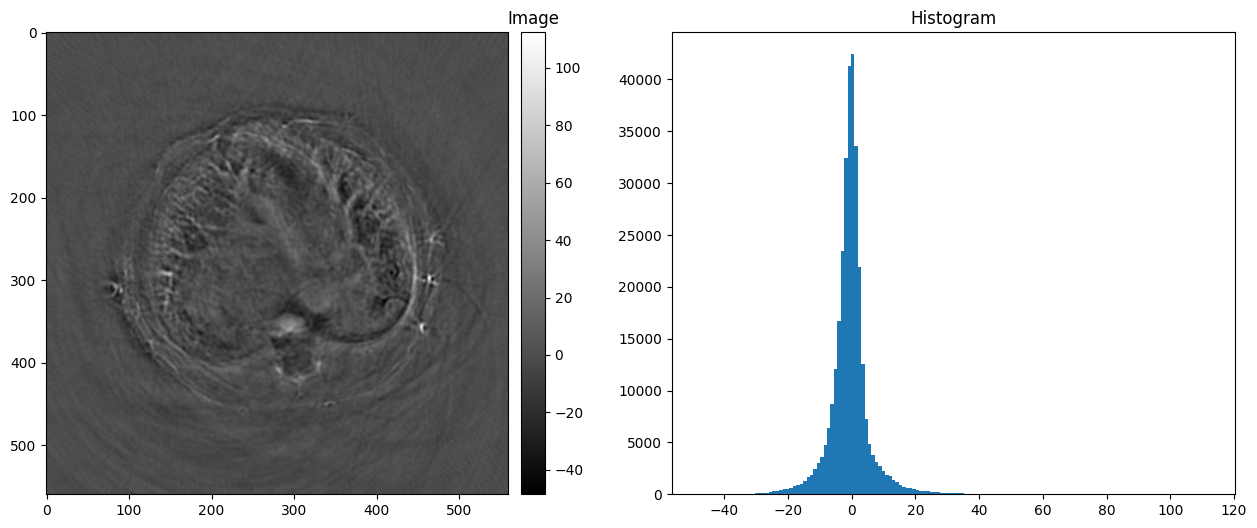

In [64]:
fig = plt.figure(figsize=(16,6))
ax1 = plt.subplot(1,2,1)
plt.imshow(baseline, cmap='gray')
cax = fig.add_axes([ax1.get_position().x1+0.008, ax1.get_position().y0, 0.015, ax1.get_position().height])
cb = plt.colorbar(cax=cax)
cb.ax.tick_params(labelsize=10)
plt.title('Image', fontsize=12)

ax2 = plt.subplot(1,2,2)
plt.hist(baseline.ravel(), bins=150)
plt.title('Histogram', fontsize=12)

### Deconvolution with Single Body PSFs

In [65]:
def get_delays(R, v0, v1, n_delays, mode='linear'):
    if mode == 'linear':
        return np.linspace(0, (1-v0/v1) * R, n_delays)
    elif mode == 'quadric':
        return (1-v0/v1) * R * np.sqrt(np.linspace(0,1,n_delays))
    else:
        raise NotImplementedError()
    
n_delays = 16
delays = get_delays(R, v0, v1, n_delays, 'linear')
print(delays)

recons = []
for d_delay in delays:
    recon = delay_and_sum(R_ring=0.05,
                          T_sample=1/(40e6), 
                          V_sound=v0,
                          Sinogram=sinogram_deconv[:,70:],
                          ImageX=kgrid.x_vec[:],
                          ImageY=kgrid.y_vec[:],
                          d_delay=d_delay,
                          ring_error=ring_error)
    recons.append(recon)

[0.00000000e+00 3.68931551e-06 7.37863102e-06 1.10679465e-05
 1.47572620e-05 1.84465776e-05 2.21358931e-05 2.58252086e-05
 2.95145241e-05 3.32038396e-05 3.68931551e-05 4.05824706e-05
 4.42717861e-05 4.79611016e-05 5.16504171e-05 5.53397327e-05]


In [66]:
recons = np.array(recons)
recons = recons[:,x_c-img_size//2:x_c+img_size//2, y_c-img_size//2:y_c+img_size//2]

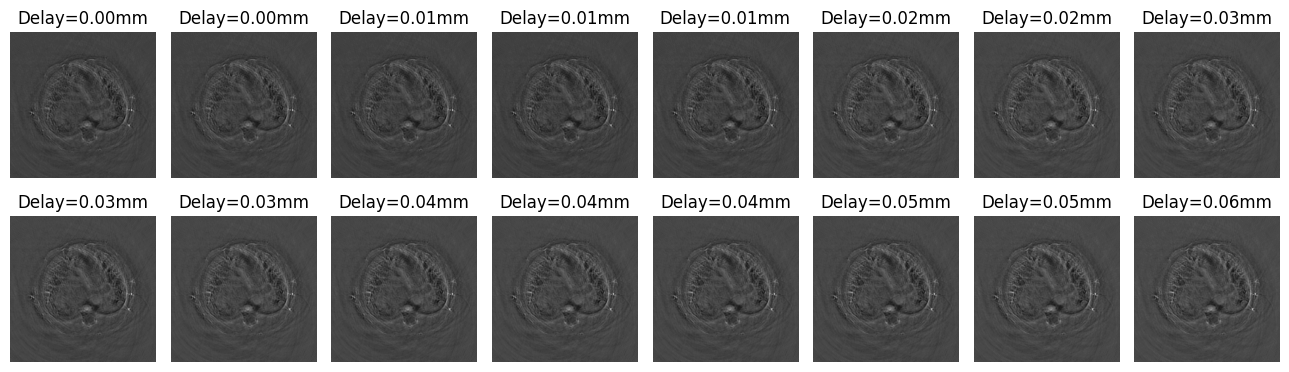

In [67]:
plt.figure(figsize=(13, 4))
for idx, d_delay in enumerate(delays):
    ax1 = plt.subplot(2,8,idx+1)
    plt.imshow(recons[idx,:,:], cmap='gray')
    plt.title('Delay={:.2f}mm'.format(d_delay*1e3), fontsize=12)
    plt.axis('off')
plt.tight_layout()

In [68]:
l = 3.2e-3        
psfs, obss = [], []
recons = np.array(recons)
for i in range(25):
    for j in range(25):
        obs = torch.Tensor(recons[:,20*i:20*i+80, 20*j:20*j+80])
        obss.append(obs)
        
        x, y = (j-12)*l / 4, (12-i)*l / 4
        r, phi = np.sqrt(x**2 + y**2), np.arctan2(x, y)
        w_real = wavefront_real(R, r, phi, v0, v1)
        k2D, theta2D = get_fourier_coord(n_points=80, l=l, device='cpu')
        psf = []
        for id, delay in enumerate(delays):
            psf.append(PSF(theta2D, k2D, w_real, delay))
        psfs.append(torch.stack(psf, dim=0))

In [69]:
wiener = Wiener_Batched(lam=0.07)
admm = ADMM_Batched(n_iters=16, lam=0.1, rho=0.03)

### Small Patch

In [70]:
i, j = 15, 21
x, y = (j-12)*l / 4, (12-i)*l / 4
r = np.sqrt(x**2 + y**2)
C0 = (1-v0/v1) * R * (1 - (r**2)/(4*R**2))
print('r={:.2f}mm   C0={:.2f}mm'.format(r*1e3, C0*1e3))

r=7.59mm   C0=0.04mm


In [71]:
obs, psf = torch.Tensor(obss[i*25+j]), psfs[i*25+j]
obs, psf = obs.unsqueeze(0).to(device), psf.unsqueeze(0).to(device)
mean = obs.abs().mean()
with torch.no_grad():
    rec_wiener = wiener(obs/mean, psf) * mean
    rec_admm = admm(obs/mean, psf) * mean
obs = obs.squeeze(0).detach().cpu().numpy()
psf = psf.squeeze(0).detach().cpu().numpy()
rec_wiener = rec_wiener.squeeze(0).squeeze(0).detach().cpu().numpy()
rec_wiener /= np.abs(rec_wiener).mean()
rec_admm = rec_admm.squeeze(0).squeeze(0).detach().cpu().numpy()
rec_admm /= np.abs(rec_admm).mean()

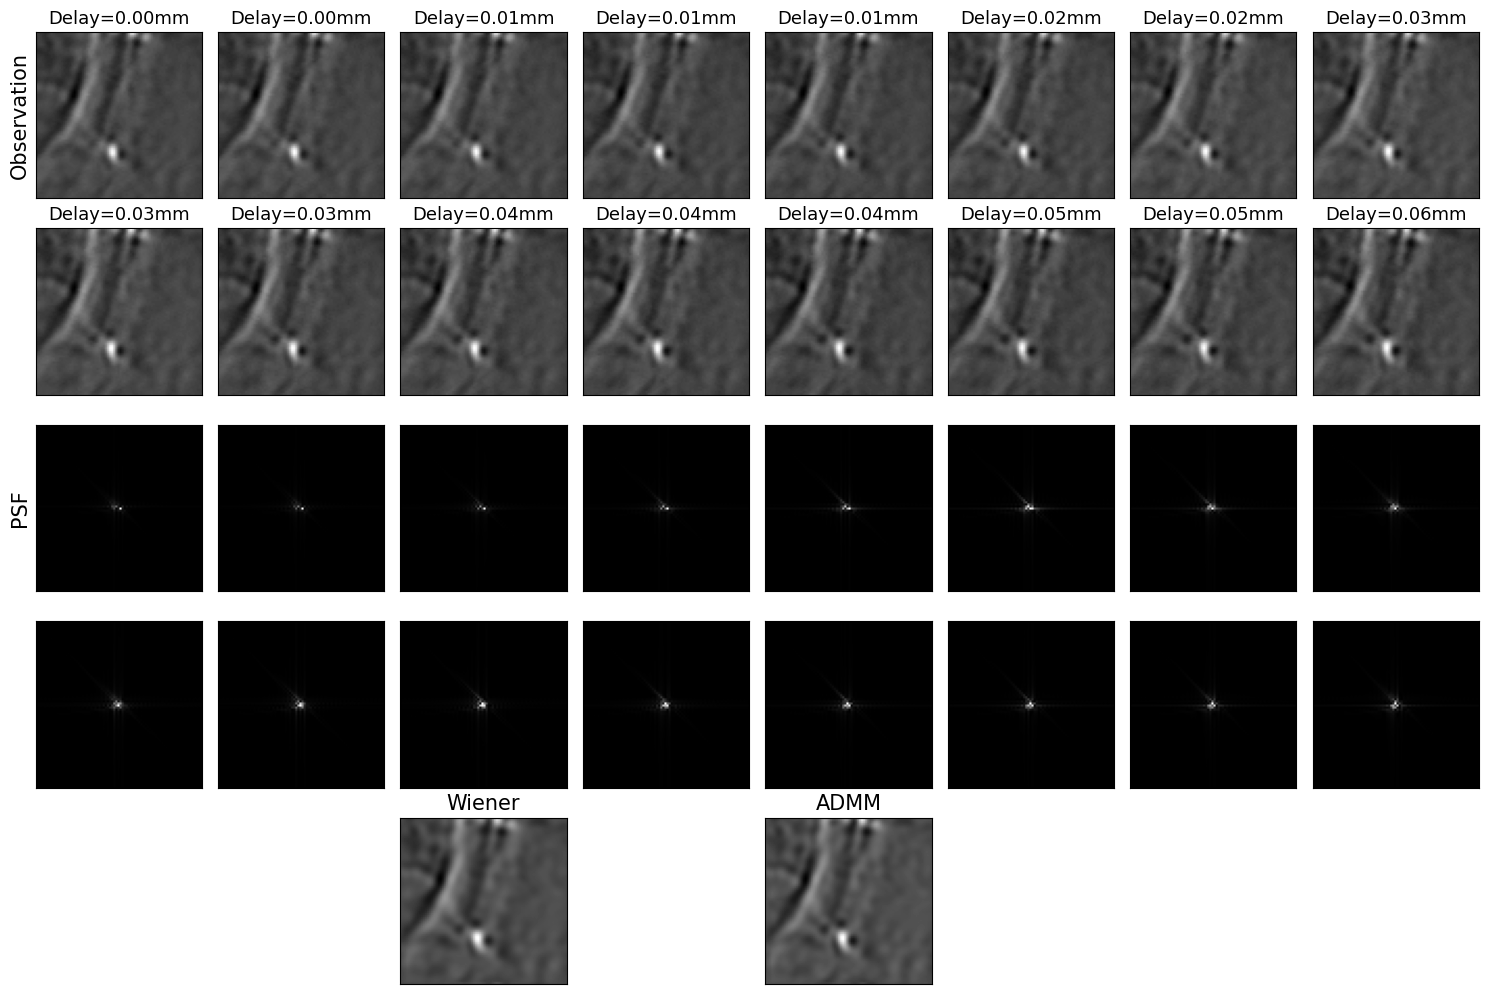

In [72]:
plt.figure(figsize=(15,10))
for i in range(n_delays):
    plt.subplot(5,8,i+1)
    plt.imshow(obs[i], cmap='gray')
    plt.title('Delay={:.2f}mm'.format(delays[i]*1e3), fontsize=13)
    plt.xticks([])
    plt.yticks([])
    if i == 0:
        plt.ylabel('Observation', fontsize=15)
    
    plt.subplot(5,8,i+1+n_delays)
    plt.imshow(psf[i], cmap='gray')
    plt.xticks([])
    plt.yticks([])
    if i == 0:
        plt.ylabel('PSF', fontsize=15)
    
plt.subplot(5,8,3+2*n_delays)
plt.imshow(rec_wiener, cmap='gray')
plt.xticks([])
plt.yticks([])
plt.title('Wiener', fontsize=15)

plt.subplot(5,8,5+2*n_delays)
plt.imshow(rec_admm, cmap='gray')
plt.xticks([])
plt.yticks([])
plt.title('ADMM', fontsize=15)

plt.tight_layout()

In [73]:
def gaussian_kernel(sigma, size):
    function = lambda x,y: np.exp(-((x-(size-1)/2)**2 + (y-(size-1)/2)**2) / (2*(sigma**2)))
    kernel = np.fromfunction(function, (size, size), dtype=float)
    return kernel / np.sum(kernel)

fwhm = 1.5e-3 # [m]
sigma = fwhm / 4e-5 / np.sqrt(2*np.log(2))
gaussian_window = gaussian_kernel(sigma, 80)

In [74]:
def deconv_full_img(model, recons, gaussian_window):
    model.to(device)
    model.eval()

    rec_full = np.zeros_like(recons[0])
    for i in range(25):
        for j in range(25):
            obs, psf = obss[i*25+j], psfs[i*25+j]
            mean = obs.abs().mean()
            obs, psf = obs.unsqueeze(0).to(device), psf.unsqueeze(0).to(device)
            with torch.no_grad():
                rec = model(obs/mean, psf) * mean
            rec = rec.squeeze(0).squeeze(0).detach().cpu().numpy()
            rec_full[20*i:20*i+80, 20*j:20*j+80] += rec * gaussian_window
    
    return rec_full


rec_full_wiener = deconv_full_img(wiener, recons, gaussian_window)
rec_full_admm = deconv_full_img(admm, recons, gaussian_window)

In [75]:
baseline = baseline / np.abs(baseline).mean()
rec_full_wiener = rec_full_wiener / np.abs(rec_full_wiener).mean()
rec_full_admm = rec_full_admm / np.abs(rec_full_admm).mean()

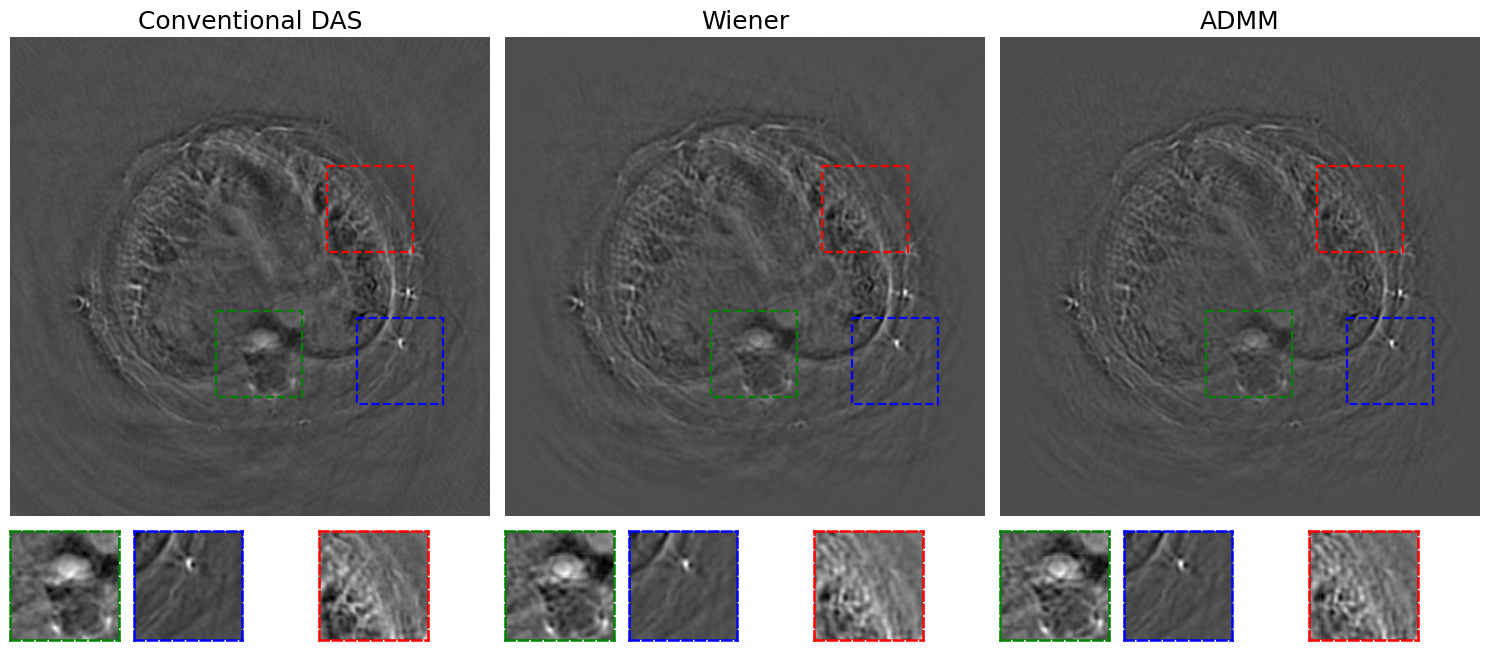

In [76]:
patches = [(320, 240, 100, 100, 'green'), (328, 405, 100, 100, 'blue'), (150, 370, 100, 100, 'red')]

fig = plt.figure(figsize=(15, 6.5))
gs = gridspec.GridSpec(5, 12)
for idx, (rec_full, method) in enumerate(zip([baseline, rec_full_wiener, rec_full_admm], ['Conventional DAS', 'Wiener', 'ADMM'])):
    ax = plt.subplot(gs[0:4,idx*4:(idx+1)*4])
    plt.imshow(rec_full, cmap='gray')
    plt.title(method, fontsize=18)
    plt.axis('off')
    for k, (x, y, h, w, color) in enumerate(patches):
        rect = plt.Rectangle((y, x), w, h, fill=False, edgecolor=color, linewidth=1.6, linestyle='--')
        ax.add_patch(rect)
        ax2 = plt.subplot(gs[4:5,idx*4+k:idx*4+k+1+(k==2)])
        plt.imshow(rec_full[x:x+h, y:y+w], cmap='gray')
        plt.xticks([])
        plt.yticks([])
        for loc in ['bottom', 'top', 'left', 'right']:
            ax2.spines[loc].set_color(color)
            ax2.spines[loc].set_linewidth(1.8)
            ax2.spines[loc].set_linestyle('--')
    # cax = fig.add_axes([ax1.get_position().x1+0.01, ax1.get_position().y0, 0.012, ax1.get_position().height])
    # cb = plt.colorbar(cax=cax)
plt.tight_layout()

### WienerNet

In [77]:
# plt.figure(figsize=(14, 4))
# for idx, d_delay in enumerate(delays):
#     x, y = 320, 480
#     plt.subplot(2,8,idx+1)
#     plt.imshow(recons[idx,x:x+80,y:y+80], cmap='gray')
#     plt.title('Delay={:.2f}mm'.format(d_delay*1e3), fontsize=12)
#     plt.axis('off')
    
#     x, y = 280, 260
#     plt.subplot(2,8,idx+9)
#     plt.imshow(recons[idx,x:x+80,y:y+80], cmap='gray')
#     plt.axis('off')
# plt.tight_layout()

In [78]:
# ncs = [32, 16, 8]
# rec_fulls = []
# pretrained_epochs = [29, 25, 50] # MultiScale
# loss = 'MultiScale' # 'MSE'
# for nc, pretrained_epoch in zip(ncs, pretrained_epochs):
#     model = WienerNet(nc=[nc, nc*2, nc*4, nc*8])
#     model.to(device)
#     pretrained_file = os.path.join('../saved_models_Mice_new1/', f'WienerNet_{nc}channels_{loss}_{pretrained_epoch}epochs.pth')
#     model.load_state_dict(torch.load(pretrained_file, map_location=torch.device(device)))
#     print(f'Successfully loaded in {pretrained_file}.')
#     model.eval()
    
#     rec_full, weights = np.zeros_like(recons[3]), np.zeros_like(recons[3])
#     for i in range(25):
#         for j in range(25):
#             obs, psf = obss[i*25+j], psfs[i*25+j]
#             mean = obs.abs().mean()
#             obs, psf = obs.unsqueeze(0).to(device), psf.to(device)
#             with torch.no_grad():
#                 rec = model(obs/mean, psf) * mean
#             rec = rec.squeeze(0).squeeze(0).detach().cpu().numpy()
#             rec_full[20*i:20*i+80, 20*j:20*j+80] += rec * gaussian_window

#     rec_fulls.append(rec_full/np.abs(rec_full).mean())

In [79]:
# fig = plt.figure(figsize=(13, 12))

# ax2 = plt.subplot(2,2,1)
# plt.imshow(baseline, cmap='gray')
# plt.title('DAS', fontsize=16)
# plt.axis('off')
# cax = fig.add_axes([ax2.get_position().x1+0.01, ax2.get_position().y0, 0.012, ax2.get_position().height])
# cb = plt.colorbar(cax=cax)

# ax4 = plt.subplot(2,2,2)
# plt.imshow(rec_fulls[0], cmap='gray')
# plt.title(f'WienerNet ({ncs[0]} channels)', fontsize=16)
# plt.axis('off')
# cax = fig.add_axes([ax4.get_position().x1+0.01, ax4.get_position().y0, 0.012, ax4.get_position().height])
# cb = plt.colorbar(cax=cax)

# ax5 = plt.subplot(2,2,3)
# plt.imshow(rec_fulls[1], cmap='gray')
# plt.title(f'WienerNet ({ncs[1]} channels)', fontsize=16)
# plt.axis('off')
# cax = fig.add_axes([ax5.get_position().x1+0.01, ax5.get_position().y0, 0.012, ax5.get_position().height])
# cb = plt.colorbar(cax=cax)

# ax6 = plt.subplot(2,2,4)
# plt.imshow(rec_fulls[2], cmap='gray')
# plt.title(f'WienerNet ({ncs[2]} channels)', fontsize=16)
# plt.axis('off')
# cax = fig.add_axes([ax6.get_position().x1+0.01, ax6.get_position().y0, 0.012, ax6.get_position().height])
# cb = plt.colorbar(cax=cax)